In [1]:
!pip install xgboost


In [2]:
pip install imbalanced-learn

In [3]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]



from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import itertools
from collections import Counter

from statsmodels.stats.outliers_influence import variance_inflation_factor

Cargar Datos

In [5]:
import pandas as pd

df = pd.read_csv('card_transdata.csv', sep=',')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


Explicacion de columnas 

Attribute Description:

distance_from_home: This is a numerical feature representing the geographical distance in kilometers between the transaction location and the cardholder's home address.

distance_from_last_transaction: This numerical attribute measures the distance in kilometers from the location of the last transaction to the current transaction location.

ratio_to_median_purchase_price: A numeric ratio that compares the transaction's price to the median purchase price of the user's transaction history.

repeat_retailer: A binary attribute where '1' signifies that the transaction was conducted at a retailer previously used by the cardholder, and '0' indicates a new retailer.

used_chip: This binary feature indicates whether the transaction was made using a chip (1) or not (0).

used_pin_number: Another binary feature, where '1' signifies the use of a PIN number for the transaction, and '0' shows no PIN number was used.

online_order: This attribute identifies whether the purchase was made online ('1') or offline ('0').

fraud: A binary target variable indicating whether the transaction was fraudulent ('1') or not ('0').

Análisis EDA

In [6]:
df.shape

(1000000, 8)

Ver valores nulos

In [7]:
df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

Ver tipo de datos en columnas


In [8]:
df.columns

Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order', 'fraud'],
      dtype='object')

Ver duplicados 

In [9]:
df.duplicated().sum()

0

Hacer enteros 

In [10]:
int_columns = ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']
df[int_columns] = df[int_columns].astype(int)


Hacer categoricas las columnas 

In [11]:
categoricas = ['repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order', 'fraud']

df[categoricas] = df[categoricas].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype   
---  ------                          --------------    -----   
 0   distance_from_home              1000000 non-null  float64 
 1   distance_from_last_transaction  1000000 non-null  float64 
 2   ratio_to_median_purchase_price  1000000 non-null  float64 
 3   repeat_retailer                 1000000 non-null  category
 4   used_chip                       1000000 non-null  category
 5   used_pin_number                 1000000 non-null  category
 6   online_order                    1000000 non-null  category
 7   fraud                           1000000 non-null  category
dtypes: category(5), float64(3)
memory usage: 27.7 MB


In [12]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1,1,0,0,0
1,10.829943,0.175592,1.294219,1,0,0,0,0
2,5.091079,0.805153,0.427715,1,0,0,1,0
3,2.247564,5.600044,0.362663,1,1,0,1,0
4,44.190936,0.566486,2.222767,1,1,0,1,0


Quitar Outlier dataframe completo

In [13]:
 #Función para filtrar outliers en una columna específica 
def remove_outliers(df, column): 
     Q1 = df[column].quantile(0.25) 
     Q3 = df[column].quantile(0.75) 
     IQR = Q3 - Q1 
     lower_bound = Q1 - 1.5 * IQR 
     upper_bound = Q3 + 1.5 * IQR 
     return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)] 
 # Aplicar la función para las tres variables 
df_completed = remove_outliers(df, 'distance_from_home') 
df_completed = remove_outliers(df_completed, 'distance_from_last_transaction') 
df_completed = remove_outliers(df_completed, 'ratio_to_median_purchase_price') 

df_completed

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1,1,0,0,0
1,10.829943,0.175592,1.294219,1,0,0,0,0
2,5.091079,0.805153,0.427715,1,0,0,1,0
3,2.247564,5.600044,0.362663,1,1,0,1,0
4,44.190936,0.566486,2.222767,1,1,0,1,0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1,1,0,0,0
999996,19.872726,2.683904,2.778303,1,1,0,0,0
999997,2.914857,1.472687,0.218075,1,1,0,1,0
999998,4.258729,0.242023,0.475822,1,0,0,1,0


Dividir en dos dataframes

In [14]:
df_numerical = df[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']]
df_categorical = df[categoricas]

In [15]:
df_numerical.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
0,57.877857,0.311140,1.945940
1,10.829943,0.175592,1.294219
2,5.091079,0.805153,0.427715
3,2.247564,5.600044,0.362663
4,44.190936,0.566486,2.222767


In [16]:
df_categorical.head()

,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,1,1,0,0,0
1,1,0,0,0,0
2,1,0,0,1,0
3,1,1,0,1,0
4,1,1,0,1,0


Comprobación de outliers

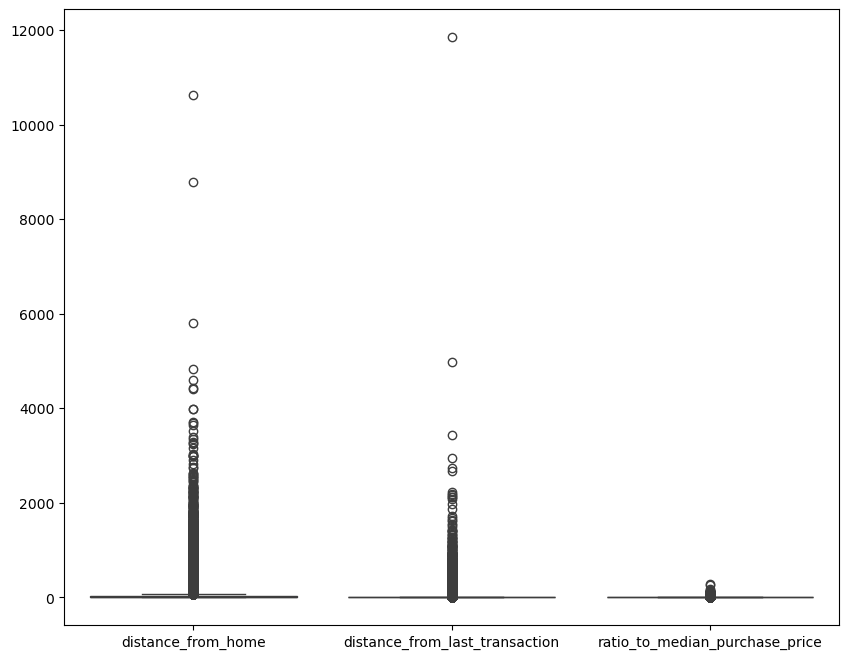

In [17]:
sns.boxplot(data=df_numerical)
plt.show()

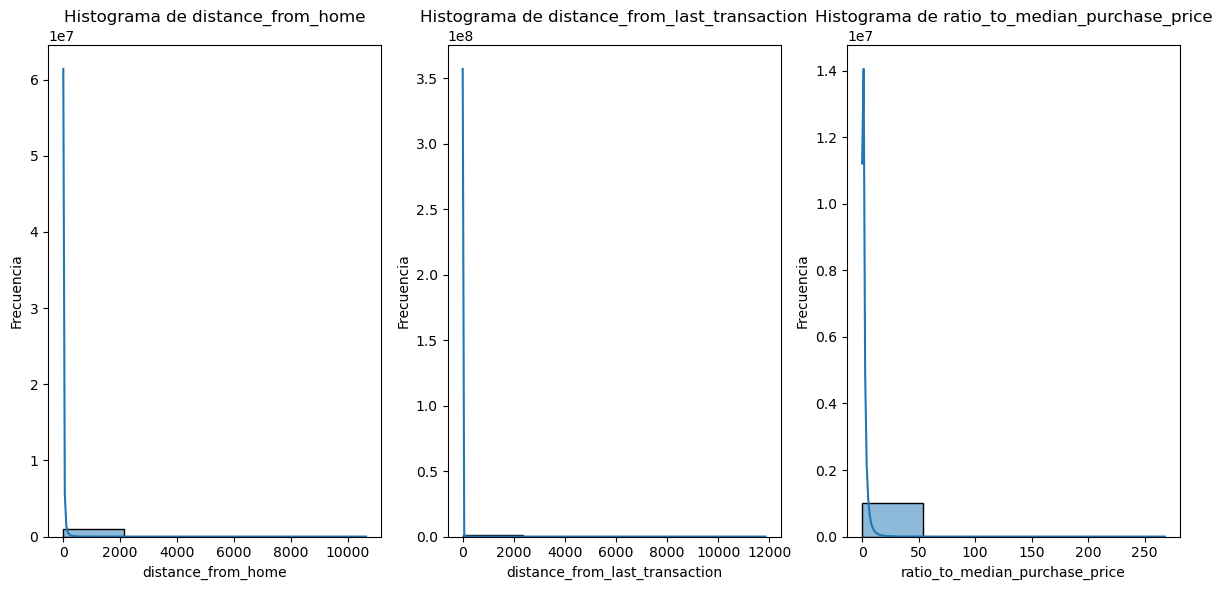

In [18]:


plt.figure(figsize=(12, 6))  # Ajustar el tamaño del gráfico

# Crear un histograma para cada columna numérica
for i, column in enumerate(df_numerical.columns):
    plt.subplot(1, len(df_numerical.columns), i + 1)  # Crear un subplot por cada columna
    sns.histplot(df_numerical[column], bins=5, kde=True)  # Gráfico de histograma
    plt.title(f'Histograma de {column}')  # Título del gráfico
    plt.xlabel(column)  # Etiqueta del eje x
    plt.ylabel('Frecuencia')  # Etiqueta del eje y

# Ajustar el layout
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Quitar outliers

In [19]:
# Calcular el IQR para cada columna
Q1 = df_numerical.quantile(0.25)
Q3 = df_numerical.quantile(0.75)
IQR = Q3 - Q1

# Definir límites para outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar el DataFrame para eliminar outliers
df_cleaned = df_numerical[~((df_numerical < lower_bound) | (df_numerical > upper_bound)).any(axis=1)]

# Mostrar el tamaño original y el tamaño después de limpiar outliers
print(f"Tamaño original: {df_numerical.shape[0]}")
print(f"Tamaño después de limpiar outliers: {df_cleaned.shape[0]}")

# Mostrar las primeras filas del DataFrame limpio
print("\nPrimeras filas del DataFrame limpio:")
print(df_cleaned.head())

Tamaño original: 1000000
Tamaño después de limpiar outliers: 718750

Primeras filas del DataFrame limpio:
   distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  
0                        1.945940  
1                        1.294219  
2                        0.427715  
3                        0.362663  
4                        2.222767  


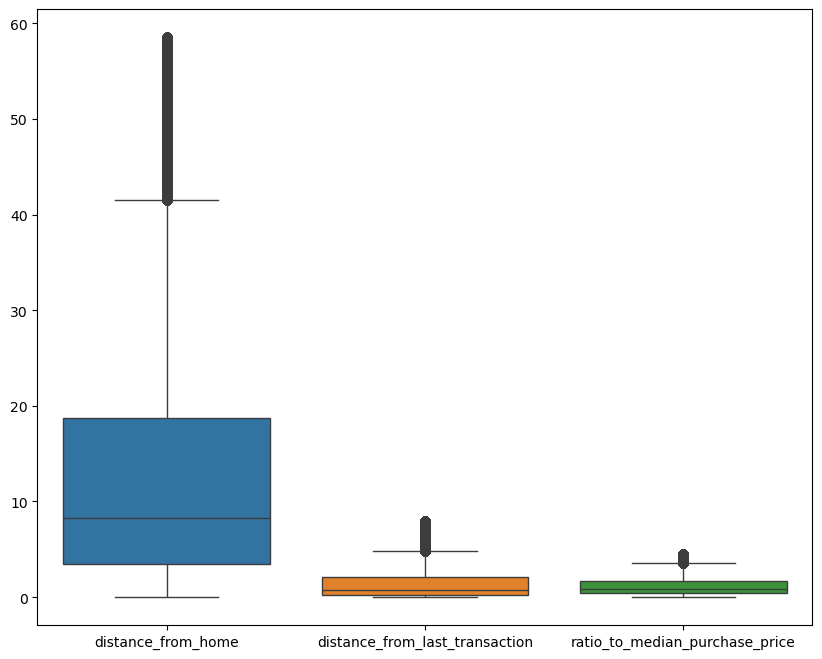

In [20]:
sns.boxplot(data=df_cleaned)
plt.show()

Ver si hay valores distintos de 0 y 1 en las columnas categoricas

In [21]:
for column in df_categorical.columns:
    unique_values = df_categorical[column].unique()
    if not set(unique_values).issubset({0, 1}):
        print(f"Valores distintos encontrados en '{column}': {unique_values}")
    else:
        print(f"No hay valores distintos de 1 y 0 en '{column}'.")

No hay valores distintos de 1 y 0 en 'repeat_retailer'.
No hay valores distintos de 1 y 0 en 'used_chip'.
No hay valores distintos de 1 y 0 en 'used_pin_number'.
No hay valores distintos de 1 y 0 en 'online_order'.
No hay valores distintos de 1 y 0 en 'fraud'.


Exploración de datos

In [22]:
df_completed.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
count,718686.000000,718686.000000,718686.000000
mean,13.212489,1.491409,1.214578
std,13.182287,1.765700,1.013669
min,0.004874,0.000118,0.004399
25%,3.439834,0.246625,0.442329
50%,8.301386,0.753125,0.888475
75%,18.675727,2.068070,1.703438
max,58.542735,7.946092,4.523808


In [23]:
df_completed.describe(include='category')

,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,718686,718686,718686,718686,718686
unique,2,2,2,2,2
top,1,0,0,1,0
freq,623713,466766,646425,467689,709694


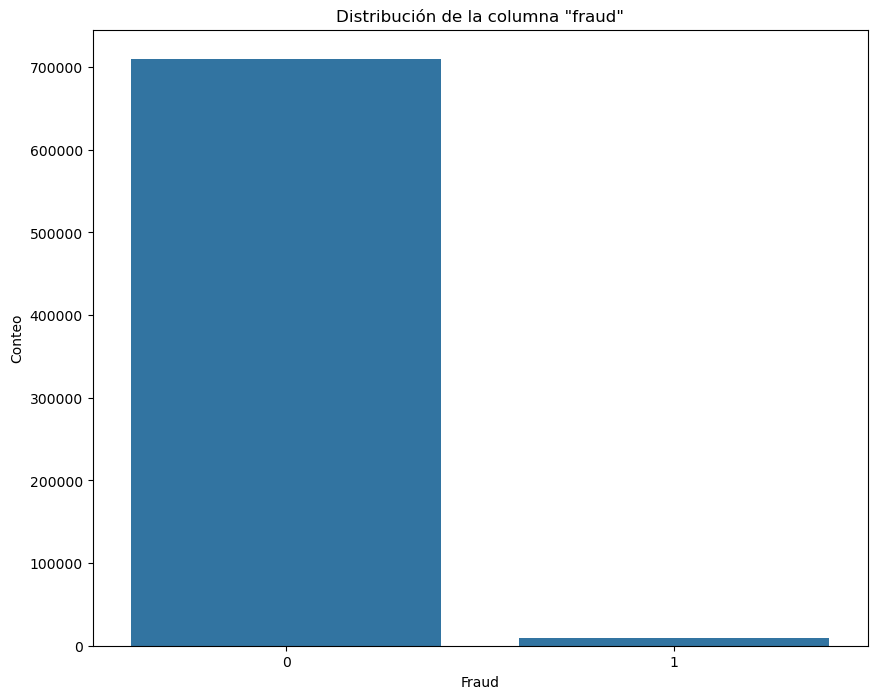

In [24]:
sns.countplot(x=df_completed['fraud'])

# Añadir título y etiquetas al gráfico
plt.title('Distribución de la columna "fraud"')
plt.xlabel('Fraud')
plt.ylabel('Conteo')

# Mostrar el gráfico
plt.show()


<Axes: >

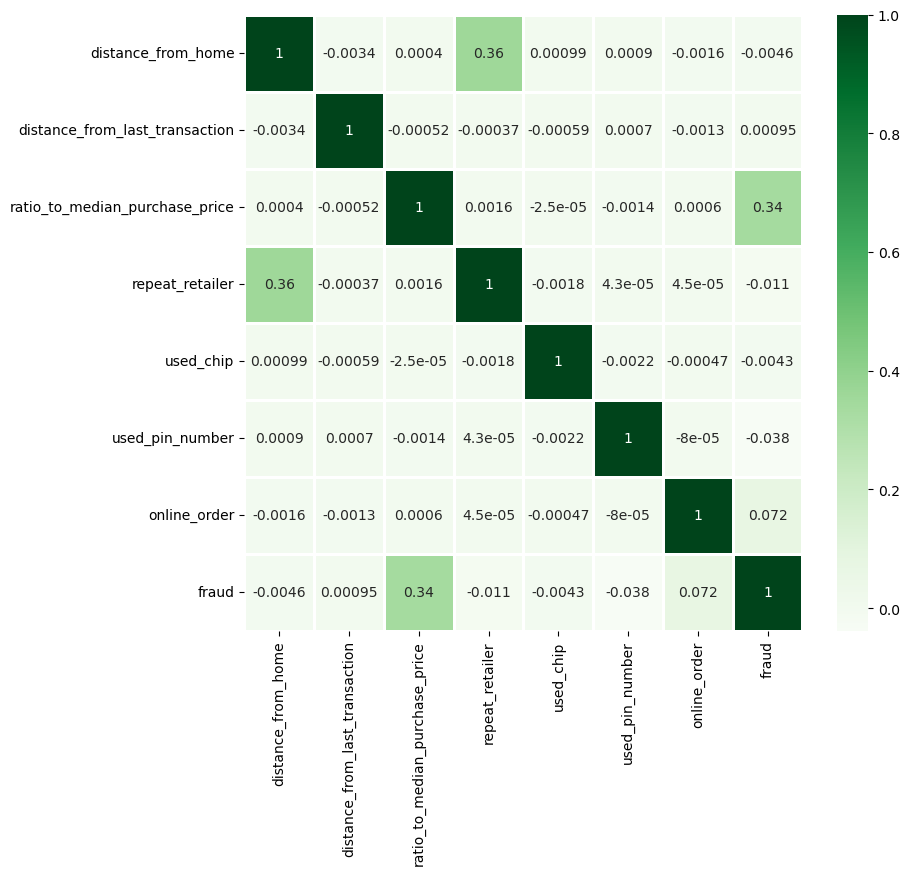

In [25]:
correlation_mat = df_completed.corr() 
f, ax = plt.subplots(figsize=(9, 8)) 
sns.heatmap(correlation_mat,ax=ax, annot=True, cmap="Greens", linewidths=0.8)

Creacion de variables dummies

In [26]:
df_completed_withdummy = pd.get_dummies(df_completed, columns=['repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order'])
df_completed_withdummy.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,fraud,repeat_retailer_0,repeat_retailer_1,used_chip_0,used_chip_1,used_pin_number_0,used_pin_number_1,online_order_0,online_order_1
0,57.877857,0.311140,1.945940,0,False,True,False,True,True,False,True,False
1,10.829943,0.175592,1.294219,0,False,True,True,False,True,False,True,False
2,5.091079,0.805153,0.427715,0,False,True,True,False,True,False,False,True
3,2.247564,5.600044,0.362663,0,False,True,False,True,True,False,False,True
4,44.190936,0.566486,2.222767,0,False,True,False,True,True,False,False,True


Crear feautures y target


In [27]:
# Feautures todas las columnas menos fraud
features= df_completed_withdummy.drop(['fraud'], axis=1)

#Target columna fraud
target = df_completed_withdummy['fraud']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=42)

Normalizar datos

In [29]:
normalize = MinMaxScaler() 
normalize.fit(X_train)

MinMaxScaler()

In [30]:
X_train_norm = normalize.transform(X_train)
X_test_norm = normalize.transform(X_test)

In [31]:
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_train_norm.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer_0,repeat_retailer_1,used_chip_0,used_chip_1,used_pin_number_0,used_pin_number_1,online_order_0,online_order_1
0,0.320236,0.048819,0.348575,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.053892,0.055039,0.034734,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.121423,0.116080,0.105526,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.126925,0.412678,0.118494,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.132819,0.207858,0.030564,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [32]:
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)
X_test_norm.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer_0,repeat_retailer_1,used_chip_0,used_chip_1,used_pin_number_0,used_pin_number_1,online_order_0,online_order_1
0,0.008748,0.103098,0.164487,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.080006,0.598708,0.446669,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.180644,0.078305,0.018378,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.496701,0.237458,0.531571,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
4,0.217109,0.433857,0.288503,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


Escalar datos

In [33]:
scaler= StandardScaler()

scaler.fit(X_train)

StandardScaler()

In [34]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_train_scaled.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer_0,repeat_retailer_1,used_chip_0,used_chip_1,used_pin_number_0,used_pin_number_1,online_order_0,online_order_1
0,0.420862,-0.624502,0.360177,-0.390126,0.390126,0.734642,-0.734642,0.334373,-0.334373,-0.733048,0.733048
1,-0.762338,-0.596523,-1.038991,-0.390126,0.390126,0.734642,-0.734642,0.334373,-0.334373,-0.733048,0.733048
2,-0.462339,-0.321933,-0.723385,-0.390126,0.390126,0.734642,-0.734642,0.334373,-0.334373,-0.733048,0.733048
3,-0.437899,1.012286,-0.665570,-0.390126,0.390126,0.734642,-0.734642,0.334373,-0.334373,1.364166,-1.364166
4,-0.411715,0.090923,-1.057580,-0.390126,0.390126,0.734642,-0.734642,0.334373,-0.334373,1.364166,-1.364166


In [36]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)
X_test_scaled.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer_0,repeat_retailer_1,used_chip_0,used_chip_1,used_pin_number_0,used_pin_number_1,online_order_0,online_order_1
0,-0.962883,-0.380331,-0.460524,2.563276,-2.563276,0.734642,-0.734642,0.334373,-0.334373,-0.733048,0.733048
1,-0.646331,1.849127,0.797500,-0.390126,0.390126,0.734642,-0.734642,0.334373,-0.334373,1.364166,-1.364166
2,-0.199256,-0.491863,-1.111907,-0.390126,0.390126,-1.361208,1.361208,0.334373,-0.334373,1.364166,-1.364166
3,1.204784,0.224076,1.176013,-0.390126,0.390126,0.734642,-0.734642,-2.990669,2.990669,1.364166,-1.364166
4,-0.037267,1.107560,0.092364,-0.390126,0.390126,-1.361208,1.361208,0.334373,-0.334373,-0.733048,0.733048


Undersampling

In [37]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Inicializar el undersampler
undersampler = RandomUnderSampler(random_state=0)

# Aplicar el undersampling a las características (X) y la variable objetivo (y)
X_under, y_under = undersampler.fit_resample(features, target)

# Verificar la nueva distribución de clases
print(f"Distribución original de clases: {Counter(target)}")
print(f"Distribución después de undersampling: {Counter(y_under)}")

# Opcional: Dividir en conjuntos de entrenamiento y prueba después de aplicar undersampling
from sklearn.model_selection import train_test_split
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.3, random_state=42)


Distribución original de clases: Counter({0: 709694, 1: 8992})
Distribución después de undersampling: Counter({0: 8992, 1: 8992})


Gradient Boosting

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

# Crear el modelo de Gradient Boosting
model = GradientBoostingClassifier(random_state=42)

# Entrenar el modelo en los datos normalizados
model.fit(X_train_under, y_train_under)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9999443431799524

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    141990
           1       1.00      1.00      1.00      1748

    accuracy                           1.00    143738
   macro avg       1.00      1.00      1.00    143738
weighted avg       1.00      1.00      1.00    143738



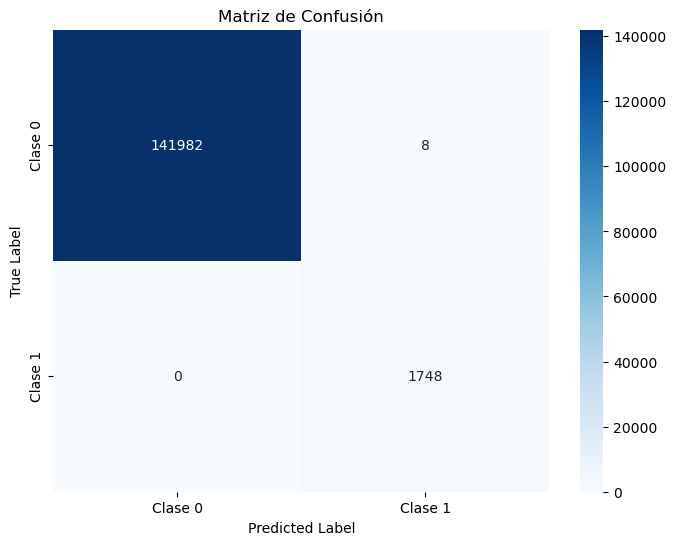

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Supongamos que y_test contiene las etiquetas reales y y_pred las predicciones
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear el gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusión')
plt.show()

Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Crear el modelo de Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo en los datos normalizados
model_rf.fit(X_train_under, y_train_under)

# Hacer predicciones
y_pred_rf = model_rf.predict(X_test)

# Evaluar el rendimiento del modelo
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


Accuracy: 0.9999791286924822

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    141990
           1       1.00      1.00      1.00      1748

    accuracy                           1.00    143738
   macro avg       1.00      1.00      1.00    143738
weighted avg       1.00      1.00      1.00    143738



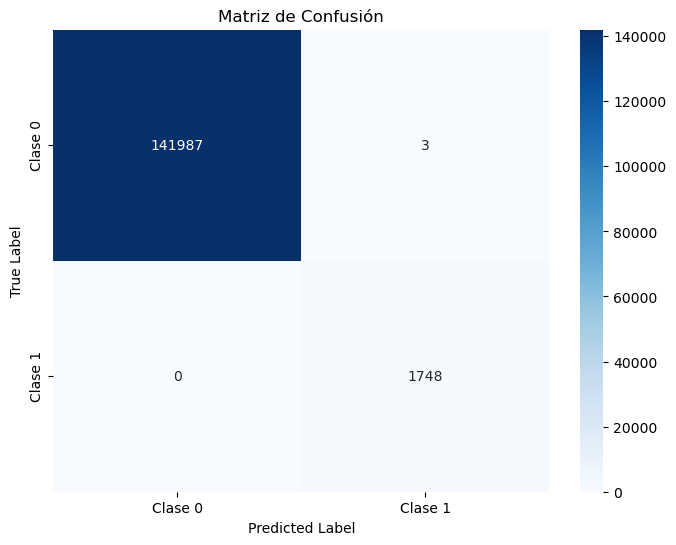

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Supongamos que y_test contiene las etiquetas reales y y_pred las predicciones
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Crear el gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusión')
plt.show()

Regresion Logistica

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Crear el modelo de Regresión Logística
model_lr = LogisticRegression(random_state=42, max_iter=1000)

# Entrenar el modelo en los datos normalizados
model_lr.fit(X_train_under, y_train_under)

# Hacer predicciones
y_pred_lr = model_lr.predict(X_test)

# Evaluar el rendimiento del modelo
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))


Accuracy: 0.9872963308241384

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    141990
           1       0.49      1.00      0.66      1748

    accuracy                           0.99    143738
   macro avg       0.74      0.99      0.83    143738
weighted avg       0.99      0.99      0.99    143738



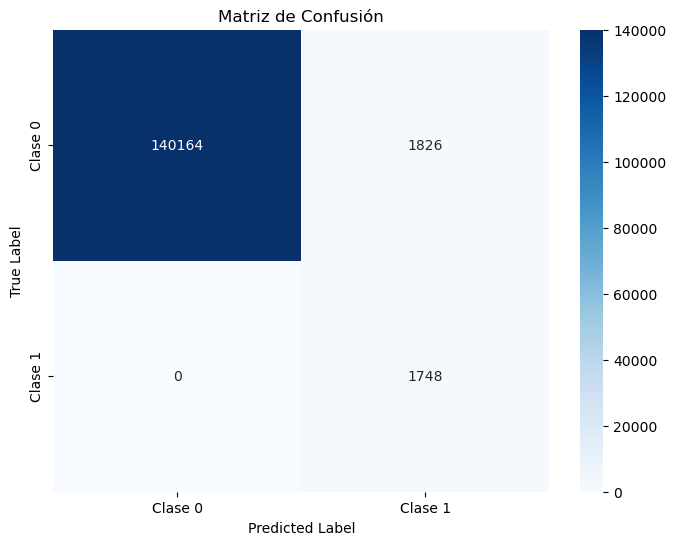

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Supongamos que y_test contiene las etiquetas reales y y_pred las predicciones
conf_matrix = confusion_matrix(y_test, y_pred_lr)

# Crear el gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusión')
plt.show()

Oversampling

In [132]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Inicializar SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE a las características (X) y la variable objetivo (y)
X_over, y_over = smote.fit_resample(features, target)

# Verificar la nueva distribución de clases después de aplicar oversampling
print(f"Distribución original de clases: {Counter(target)}")
print(f"Distribución después de oversampling: {Counter(y_over)}")

# Dividir en conjuntos de entrenamiento y prueba después de aplicar SMOTE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=42)


Distribución original de clases: Counter({0: 709694, 1: 8992})
Distribución después de oversampling: Counter({0: 709694, 1: 709694})


In [134]:
from sklearn.ensemble import GradientBoostingClassifier

# Crear el modelo de Gradient Boosting
model = GradientBoostingClassifier(random_state=42)

# Entrenar el modelo en los datos normalizados
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9999929547199854

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    212713
           1       1.00      1.00      1.00    213104

    accuracy                           1.00    425817
   macro avg       1.00      1.00      1.00    425817
weighted avg       1.00      1.00      1.00    425817



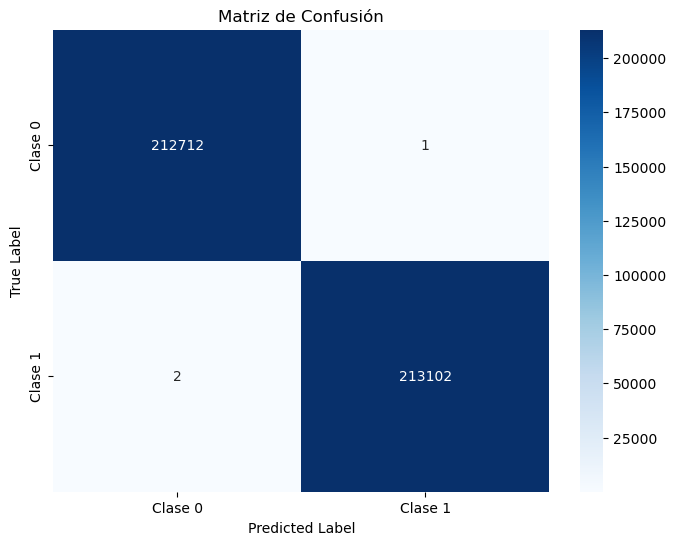

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Supongamos que y_test contiene las etiquetas reales y y_pred las predicciones
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear el gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusión')
plt.show()

Prueba modelo regresion logistica

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


logic = LogisticRegression()
logic.fit(X_train, y_train)
logic.score(X_test,y_test)
y_pred = logic.predict(X_test)
f1 = f1_score(y_test, y_pred, average='binary') 
recall = recall_score(y_test, y_pred, average='binary')
print(f1)
print(recall)

0.9959677419354839
1.0


In [120]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
report = classification_report(y_test, y_pred, target_names=['Clase 0', 'Clase 1'])
print(report)

              precision    recall  f1-score   support

     Clase 0       1.00      0.99      1.00      2679
     Clase 1       0.99      1.00      1.00      2717

    accuracy                           1.00      5396
   macro avg       1.00      1.00      1.00      5396
weighted avg       1.00      1.00      1.00      5396



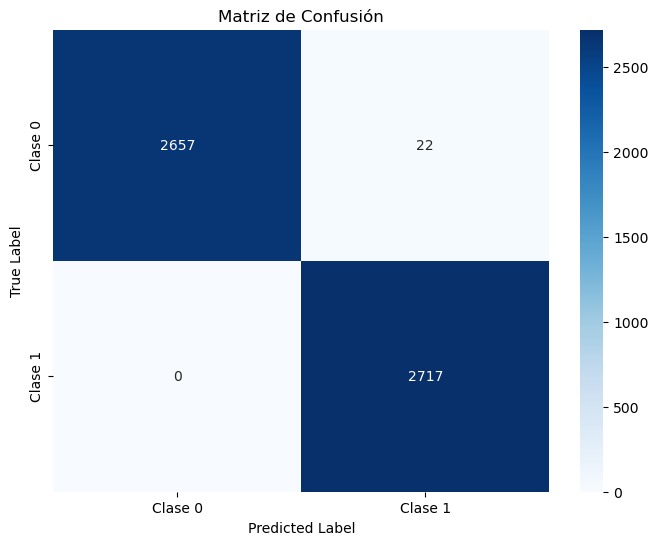

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Supongamos que y_test contiene las etiquetas reales y y_pred las predicciones
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear el gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusión')
plt.show()

Prueba modelo arbol 

In [136]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

tree = DecisionTreeClassifier()
tree.fit(X_train_norm, y_train)

y_pred_tree = tree.predict(X_test_norm)
f1_tree= f1_score(y_test, y_pred_tree, average='binary') # Calcular Recall (para clasificación binaria) 
recall_tree = recall_score(y_test, y_pred_tree, average='binary')
print(f1_tree)
print(recall_tree)


ValueError: Number of labels=993571 does not match number of samples=574948

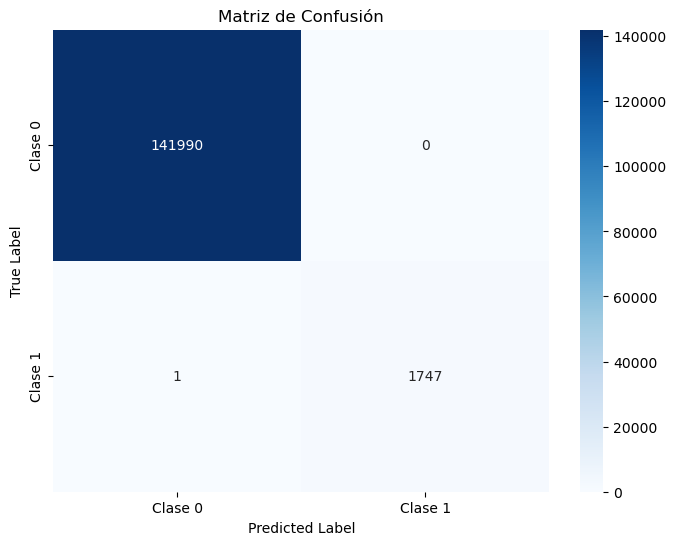

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Supongamos que y_test contiene las etiquetas reales y y_pred las predicciones
conf_matrix = confusion_matrix(y_test, y_pred_tree)

# Crear el gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusión')
plt.show()

Modelo Gradient Boosting

In [104]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Inicializar el modelo de Gradient Boosting
model = GradientBoostingClassifier(random_state=42)

# Entrenar el modelo en los datos balanceados
model.fit(X_train_norm, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_Gra = model.predict(X_test_norm)
y_pred_proba_Gra = model.predict_proba(X_test_norm)[:, 1]

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred_Gra))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_Gra))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_Gra))


Accuracy: 0.999993042897494
ROC AUC Score: 0.9999997663160924

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    141990
           1       1.00      1.00      1.00      1748

    accuracy                           1.00    143738
   macro avg       1.00      1.00      1.00    143738
weighted avg       1.00      1.00      1.00    143738



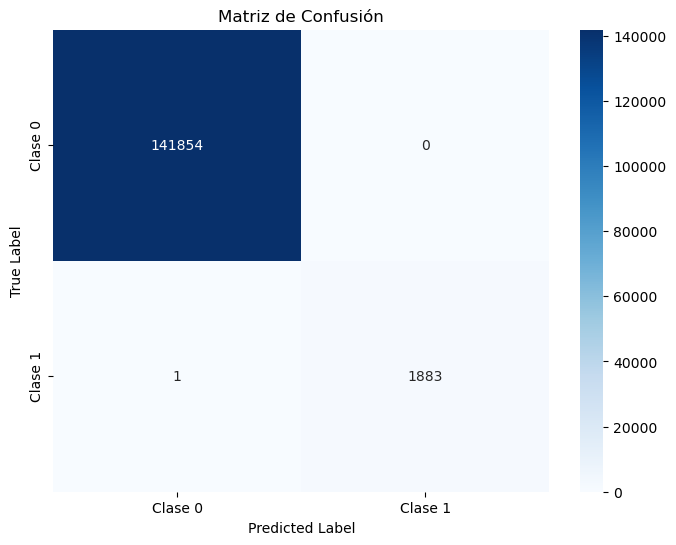

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Supongamos que y_test contiene las etiquetas reales y y_pred las predicciones
conf_matrix = confusion_matrix(y_test, y_pred_Gra)

# Crear el gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusión')
plt.show()

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


logic = LogisticRegression()
logic.fit(X_train_scaled, y_train)
logic.score(X_test_scaled,y_test)
y_pred = logic.predict(X_test_scaled)
f1 = f1_score(y_test, y_pred, average='binary') 
recall = recall_score(y_test, y_pred, average='binary')
print(f1)
print(recall)

0.9490150637311703
0.937070938215103


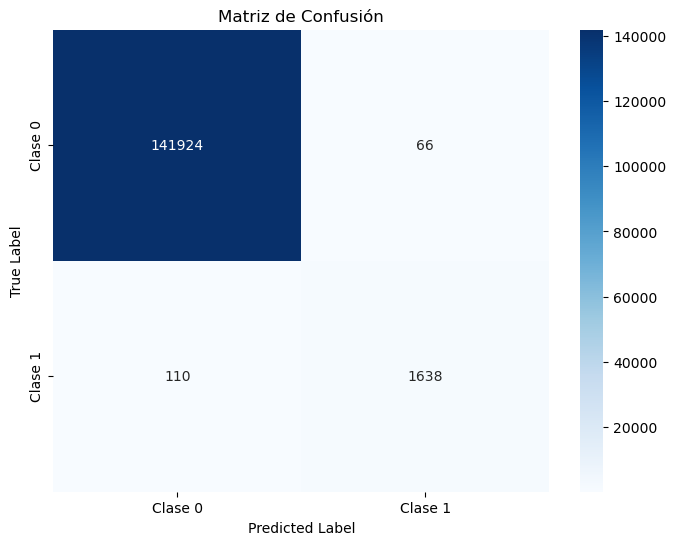

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Supongamos que y_test contiene las etiquetas reales y y_pred las predicciones
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear el gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusión')
plt.show()

In [127]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Inicializar el modelo de Gradient Boosting
model = GradientBoostingClassifier(random_state=42)

# Entrenar el modelo en los datos balanceados
model.fit(X_train_scaled, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_scaled = model.predict(X_test_scaled)


# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred_scaled))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_scaled))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_scaled))


Accuracy: 0.9998146775389177
ROC AUC Score: 0.9998133631952221

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2679
           1       1.00      1.00      1.00      2717

    accuracy                           1.00      5396
   macro avg       1.00      1.00      1.00      5396
weighted avg       1.00      1.00      1.00      5396



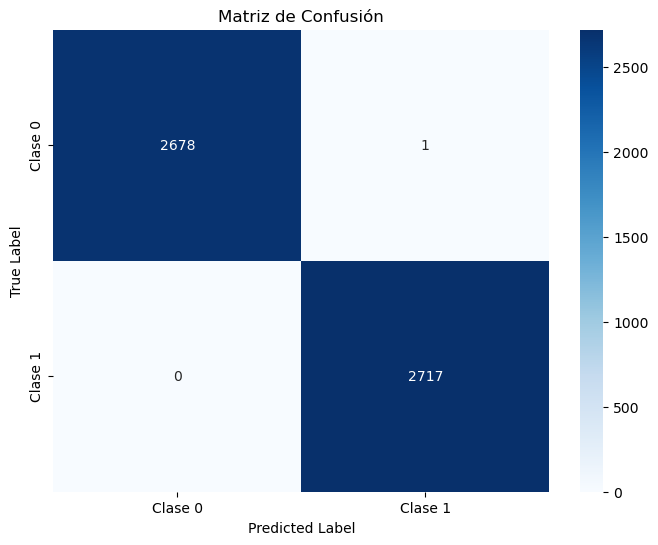

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Supongamos que y_test contiene las etiquetas reales y y_pred las predicciones
conf_matrix = confusion_matrix(y_test, y_pred_scaled)

# Crear el gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusión')
plt.show()